In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [13]:
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Enhance contrast using histogram equalization
    equalized_image = cv2.equalizeHist(blurred_image)
    
    # Detect edges using Canny edge detector
    edges = cv2.Canny(equalized_image, 100, 200)
    
    # Plot the original and processed images
    fig, axes = plt.subplots(2, 3, figsize=(10, 8))
    axes[0, 0].set_title('Original Image')
    axes[0, 0].imshow(original_image)
    axes[0, 1].set_title('Grayscale Image')
    axes[0, 1].imshow(gray_image, cmap='gray')
    axes[0, 2].set_title('Gaussian Blur')
    axes[0, 2].imshow(blurred_image, cmap='gray')
    axes[1, 0].set_title('Histogram Equalization')
    axes[1, 0].imshow(equalized_image, cmap='gray')
    axes[1, 1].set_title('Canny Edges')
    axes[1, 1].imshow(edges, cmap='gray')
    for ax in axes.flatten():
        ax.axis('off')
    plt.tight_layout()
    st.pyplot(fig)
    
    # Resize to a fixed size
    resized_image = cv2.resize(edges, (128, 128))
    
    # Convert processed image to 3-channel format
    processed_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
    return processed_image


In [14]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

NameError: name 'st' is not defined

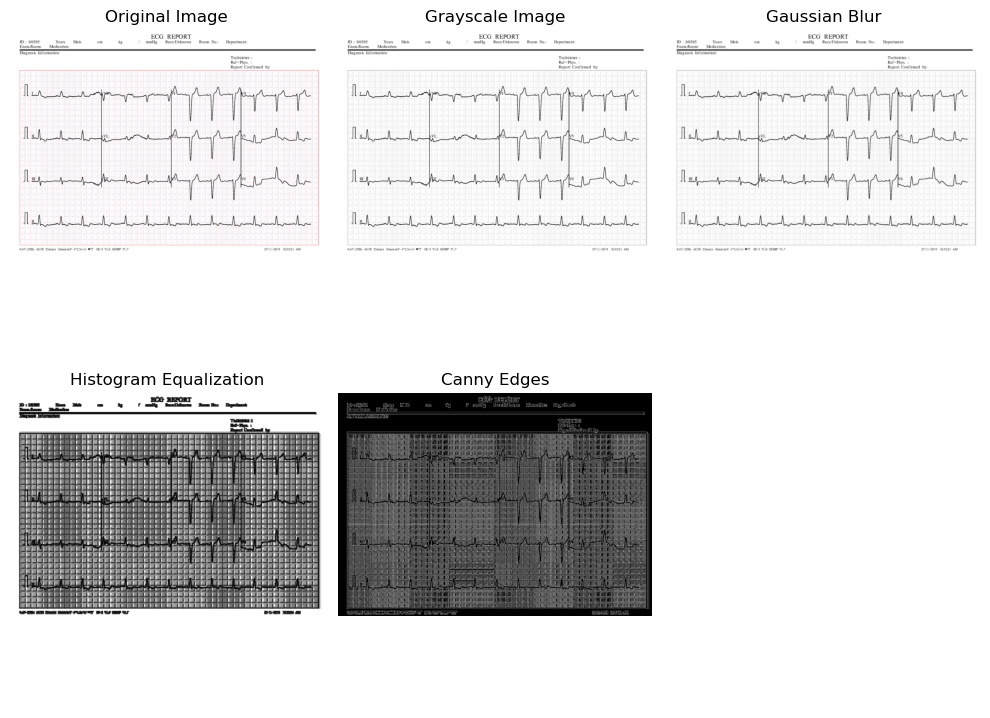

In [16]:

# Define the CNN-LSTM hybrid model
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        self.lstm = nn.LSTM(64 * 28 * 28, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, c_n) = self.lstm(r_in)
        out = self.fc(r_out[:, -1, :])
        return out

# Preprocessing function for the model
def prepare_image_for_model(processed_image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    image = transform(processed_image)
    image = image.unsqueeze(0).unsqueeze(0)  # Add batch and time dimensions
    return image

# Load the model
def load_model(model_path):
    num_classes = 3
    model = CNNLSTM(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Make a prediction
def predict(model, image_tensor):
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Example usage
model_path = 'LSTM'  # Path to the saved model
image_path = r'Normal (104).jpg'  # Path to the new ECG image

# Preprocess the image
processed_image = preprocess_image(image_path)

# Prepare the image for the model
image_tensor = prepare_image_for_model(processed_image)

# Load the model
model = load_model(model_path)

# Make a prediction
prediction = predict(model, image_tensor)
print(f'Predicted class: {prediction}')
class_names = {0: 'Abnormal', 1: 'Covid', 2: 'Normal'}
predicted_class = class_names[prediction]
print(f'Predicted class: {predicted_class}')


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, Input

class CNNLSTM(Model):
    def __init__(self, num_filters, kernel_size, pool_size, lstm_units, dense_units, **kwargs):
        super(CNNLSTM, self).__init__(**kwargs)
        self.conv = Conv2D(filters=num_filters, kernel_size=kernel_size, activation='relu')
        self.pool = MaxPooling2D(pool_size=pool_size)
        self.flatten = Flatten()
        self.reshape = Reshape(target_shape=(-1, num_filters))  # Reshape to (batch_size, timesteps, features)
        self.lstm = LSTM(units=lstm_units)
        self.dense = Dense(units=dense_units, activation='relu')
        self.output_layer = Dense(units=3, activation='softmax')  # Assuming 3 classes: Abnormal, Covid, Normal

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.reshape(x)
        x = self.lstm(x)
        x = self.dense(x)
        return self.output_layer(x)

    def get_config(self):
        base_config = super(CNNLSTM, self).get_config()
        return {
            **base_config,
            "num_filters": self.conv.filters,
            "kernel_size": self.conv.kernel_size,
            "pool_size": self.pool.pool_size,
            "lstm_units": self.lstm.units,
            "dense_units": self.dense.units,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Example instantiation
model = CNNLSTM(num_filters=32, kernel_size=(3, 3), pool_size=(2, 2), lstm_units=64, dense_units=32)


In [9]:
model.save('LSTM_model.h5')


In [10]:
from tensorflow.keras.models import load_model

custom_objects = {'CNNLSTM': CNNLSTM}
model = load_model('LSTM_model.h5', custom_objects=custom_objects)
